<a href="https://colab.research.google.com/github/Lucas-Rattighieri/tr-fqa/blob/main/TR_FQA_Modelo_ANNNI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Importação das Bibliotecas

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import numpy.linalg as npl
import scipy.linalg as la
import torch
import networkx as nx

In [ ]:
#@title Configuração Pytorch

dtype = torch.complex128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
#@title Falqon para o modelo ANNNI

def expX(psi, theta, L, indice):
    ctheta = torch.cos(theta)
    istheta = 1j * torch.sin(theta)

    for a in range(L):
        b = 1 << a
        novo_indice = indice ^ b
        # xpsi = psi[novo_indice]

        psi.mul_(ctheta).sub_(psi[novo_indice].mul(istheta))

    return psi


def hX(psi, L, indice):
    Hxpsi = torch.zeros_like(psi)

    for a in range(L):
        b = 1 << a
        novo_indice = indice ^ b
        Hxpsi.add_(psi[novo_indice])

    return Hxpsi


def falqonAnnni(L, Hp, Psi, dt, layers, beta0, g, retornar_dados=False, mostrar_dados=0):
    indice = torch.arange(2**L, dtype=torch.int64, device=Psi.device)

    Up = torch.exp(-1j * dt * Hp)
    beta = torch.tensor(beta0, device=device, dtype=torch.complex128)

    if retornar_dados:
        ev_energias = []
        ev_betas = []

    for i in range(layers):

        UpPsi = Up * Psi


        Psi = expX(UpPsi, (beta - g) * dt, L, indice)


        HpPsi = Hp * Psi
        HxPsi = hX(Psi, L, indice)

        HxHpPsi = hX(HpPsi, L, indice)

        PsiHxHpPsi = torch.vdot(Psi, HxHpPsi)

        beta = -1j * (PsiHxHpPsi - torch.conj(PsiHxHpPsi))

        if retornar_dados:
            energia = torch.vdot(Psi, HpPsi) - g * torch.vdot(Psi, HxPsi)

            ev_energias.append(float(energia.real))
            ev_betas.append(float(beta.real))

            if mostrar_dados and i % mostrar_dados == 0:
                print(f"Layer {i}, E = {energia.real}")

    return (Psi, ev_energias, ev_betas) if retornar_dados else Psi

In [ ]:
#@title TR-Falqon para o modelo ANNNI


def TR_falqonAnnni(L, Hp, Psi, dt, layers, a, tf, frt, dfrt, beta0, g, retornar_dados=False, mostrar_dados=0):
    indice = torch.arange(2**L, dtype=torch.int64, device=Psi.device)

    beta = torch.tensor(beta0, device=device, dtype=torch.complex128)

    if retornar_dados:
        ev_energias = []
        ev_betas = []

    for i in range(layers):

        df_tau = dfrt(dt * (i+1), tf, a)
        Up = torch.exp(-1j * Hp * df_tau * dt)
        UpPsi = Up * Psi

        Psi = expX(UpPsi, df_tau * (beta - g) * dt, L, indice)

        HpPsi = Hp * Psi
        HxPsi = hX(Psi, L, indice)

        HxHpPsi = hX(HpPsi, L, indice)
        PsiHxHpPsi = torch.vdot(Psi, HxHpPsi)
        beta = -1j * (PsiHxHpPsi - torch.conj(PsiHxHpPsi)) / dfrt(dt * (i+2), tf, a)

        if retornar_dados:
            energia = torch.vdot(Psi, HpPsi) - g * torch.vdot(Psi, HxPsi)

            ev_energias.append(float(energia.real))
            ev_betas.append(float(beta.real))

            if mostrar_dados and i % mostrar_dados == 0:
                print(f"Layer {i}, E = {energia.real}")

    return (Psi, ev_energias, ev_betas) if retornar_dados else Psi

In [ ]:
#@title Funções de Reescalonamento Temporal

def frt1(tau, tf = 10, a = 1):
    return a * tau - (tf / (2 * np.pi * a)) * (a - 1) * np.sin((2 * np.pi * a / tf) * tau)


def dfrt1(tau, tf = 10, a = 1):
    return a - (a - 1) * np.cos((2 * np.pi * a / tf) * tau)



def frt2(tau, tf=10, a=1):
    return (2 * (a**2 - a**3) / tf**2) * tau**3 + (3 * (a**2 - a) / tf) * tau**2 + tau


def dfrt2(tau, tf=10, a=1):
    return (6 * (a**2 - a**3) / tf**2) * tau**2 + (6 * (a**2 - a) / tf) * tau + 1

In [ ]:
#@title Produto tensorial

def cadeiapauli(L, op, pos, coef = 1):

    if coef == 0:
        return torch.zeros(2**L, dtype=dtype, device=device)

    pos = sorted(pos)

    j = 0

    produto = torch.ones([1], dtype=dtype, device=device) * coef

    for i in pos:
        if i-j == 0:
            produto = torch.kron(produto, op)
        else:
            identidade = torch.ones(2**(i-j), dtype=dtype, device=device)
            produto = torch.kron(produto, identidade)
            produto = torch.kron(produto, op)
        j = i+1
    else:
        identidade = torch.ones(2**(L-j), dtype=dtype, device=device)
        produto = torch.kron(produto, identidade)
    return produto


def produto_tensorial(*matrizes):
    produto = matrizes[0].clone()
    for matriz in matrizes[1:]:
        produto = torch.kron(produto, matriz)
    return produto


def produto_tensorial(*matrizes):
    produto = matrizes[0].clone()
    for matriz in matrizes[1:]:
        produto = torch.kron(produto, matriz)
    return produto


def produto_tensorialnp(*matrizes):
    produto = matrizes[0].copy()
    for matriz in matrizes[1:]:
        produto = np.kron(produto, matriz)
    return produto

In [ ]:
#@title Hamiltoniano Maxcut e ANNNI

sZ = torch.tensor([1, -1], dtype=torch.complex128, device=device)
idn = torch.ones(2, dtype=torch.complex128, device=device)

def Hmaxcut(L, w):
    H = torch.zeros(2**L, dtype=torch.complex128, device=device)
    identidade = torch.ones(2**L, dtype=torch.complex128, device=device)

    for i in range(L):
        for j in range(L):
            if (w[i,j] != 0):
                ZiZj = [i, j]

                termo = cadeiapauli(L, sZ, ZiZj, w[i,j] / 2)
                H = H + termo
    return H


def Hannni(L, kappa):
    H = torch.zeros(2**L, dtype=torch.complex128, device=device)
    identidade = torch.ones(2**L, dtype=torch.complex128, device=device)

    for i in range(L):
        ZiZj = [i, (i + 1) % L]
        termo1 = cadeiapauli(L, sZ, ZiZj, -1)

        ZiZj = [i, (i + 2) % L]
        termo2 = cadeiapauli(L, sZ, ZiZj, kappa)

        H = H + termo1 + termo2
    return H

In [ ]:
#@title Desenhar grafos

def desenhar_grafo(matriz_adjacencia, classe = None, pos=None, color = None, label_pos = 0.5):
    if classe is None:
      classe = np.ones(matriz_adjacencia.shape[0])

    G = nx.from_numpy_array(np.round(matriz_adjacencia, 3))

    if pos is None:
        # pos = nx.spring_layout(G, seed=seed)
        pos = nx.circular_layout(G)

    # Criar um dicionário de cores com base nas classes
    classes_unicas = np.unique(classe)
    if color is None:
        cores = plt.get_cmap("tab10", len(classes_unicas))  # Usando a nova forma de obter o colormap
        cor_por_classe = {c: cores(i) for i, c in enumerate(classes_unicas)}
    else:
        cor_por_classe = {c: color[i] for i, c in enumerate(classes_unicas)}

    # Definir a cor de cada nó com base na classe
    node_colors = [cor_por_classe[c] for c in classe]

    nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=500, font_size=10, font_weight='bold', font_color = 'white')

    pesos = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos, edge_labels=pesos, font_color='black', label_pos = label_pos)

    plt.show()


In [ ]:
#@title H numpy ANNNI

sigma_z = np.array([[1, 0], [0, -1]], dtype = float)
sigma_x = np.array([[0, 1], [1, 0]], dtype = float)
npidn = np.array([[1, 0], [0, 1]], dtype = float)

def Hannninp(L, kappa, g):
    H = np.zeros((2 ** L, 2 ** L))

    for i in range(L):

        cadeia1 = [npidn] * L
        cadeia2 = [npidn] * L
        cadeia3 = [npidn] * L

        cadeia1[i] = sigma_z
        cadeia1[(i + 1) % L] = sigma_z

        cadeia2[i] = sigma_z
        cadeia2[(i + 2) % L] = sigma_z

        cadeia3[i] = sigma_x

        H += - produto_tensorialnp(*cadeia1) + kappa * produto_tensorialnp(*cadeia2) - g * produto_tensorialnp(*cadeia3)
    return H

In [ ]:
ckappas = [0.2, 0.8, 0.2, 0.8]
cdts = [0.01, 0.01, 0.005, 0.005]
clayers = [2000, 2000, 3000, 3000]
coef = [1, 1, 2*5/3, 5]
beta0 = 0


cLs = [8, 8, 12, 12]

In [ ]:
cenergias = {0: [], 1: [], 2: [], 3: []}
cbetas = {0: [], 1: [], 2: [], 3: []}
cefun = {0: 0, 1: 0, 2: 0, 3: 0}

clabels = {0: [], 1: [], 2: [], 3: []}

In [ ]:
grafico = 2



As = [2, 3]
dt = cdts[grafico]
layers = clayers[grafico]
kappa = ckappas[grafico]
L = cLs[grafico]
g = 0.2


cenergias[grafico] = []
cbetas[grafico] = []
clabels[grafico] = []



Hp = Hannni(L, kappa)
H = Hannninp(L, kappa, g)

Psi = torch.ones(2**L, dtype=torch.complex128, device=device)
Psi /= np.sqrt(2**L)

emin = float(np.min(npl.eigvalsh(H)))

cefun[grafico] = emin

psi, energias, betas = falqonAnnni(L, Hp, Psi, dt, layers, beta0, g, retornar_dados=True, mostrar_dados=0)

cenergias[grafico].append(energias)
cbetas[grafico].append(betas)
clabels[grafico].append("FQA")

# dt = cdts[grafico]

for a in As:
    print(a)
    tf = layers * dt * coef[grafico] * a
    lgapsi, lgaenergias, lgabetas = TR_falqonAnnni(L, Hp, Psi, dt, layers, a, tf, frt1, dfrt1, beta0, g, retornar_dados=True, mostrar_dados=0)

    cenergias[grafico].append(lgaenergias)
    cbetas[grafico].append(lgabetas)
    clabels[grafico].append(f"$a = {a}, t_f = {tf:.0f}$")

2
3


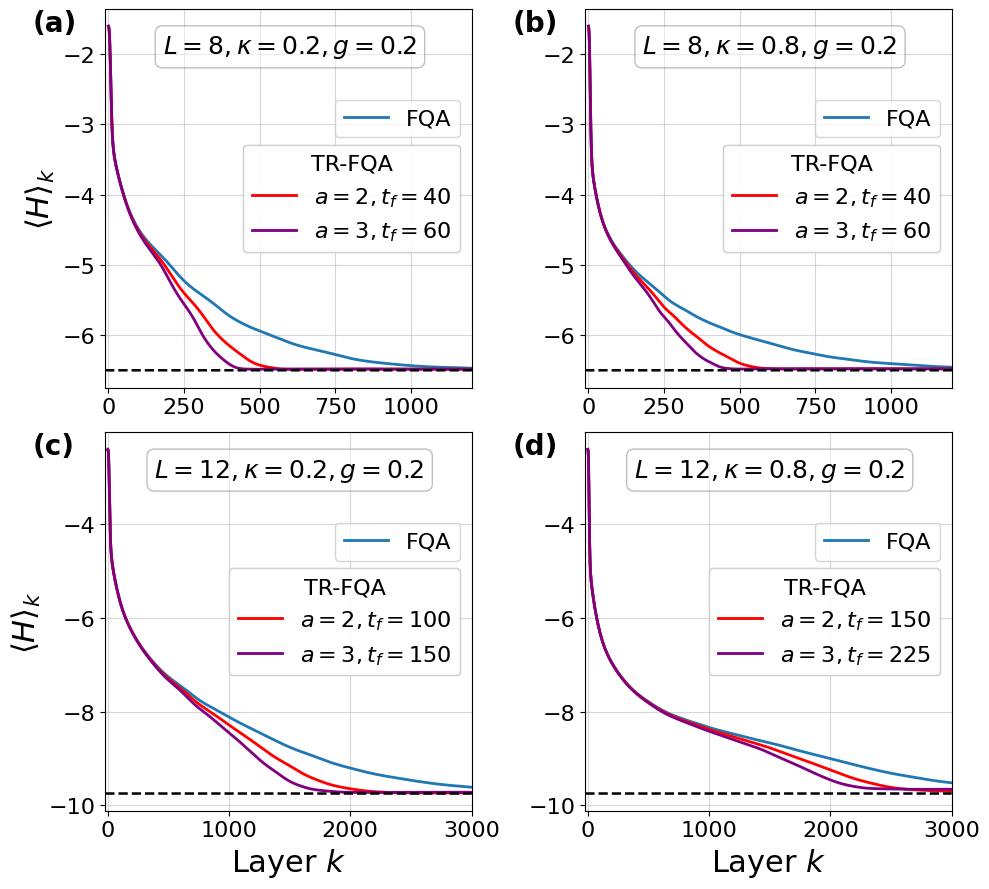

In [ ]:
figs, axs = plt.subplots(2, 2, figsize=(10, 9))

posicao_graficos = [(0,0), (0,1), (1,0), (1,1)]


bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.5)


alphas = [1, 1, 1, 1]
print_xlabel = [False, False, True, True]
print_ylabel = [True, False, True, False]

colors = ["#1f77b4", "red", "purple", "#ff595e"]
layers1 = [1200, 1200, 3000, 3000]



for k in range(4):
    layer1 = layers1[k]
    layer = clayers[k]

    handles = []
    labels = []

    for i in range(len(cenergias[k])):
        k1, k2 = posicao_graficos[k]
        line, = axs[k1,k2].plot(np.arange(layer), cenergias[k][i][:layer], '-', label=clabels[k][i], linewidth=2, alpha = alphas[i], color = colors[i])

        handles.append(line)
        labels.append(clabels[k][i])

    axs[k1,k2].plot(np.arange(-50, layer+50), np.ones(layer+100) * cefun[k], '--', color='black', linewidth=1.8)
    axs[k1,k2].grid(alpha=0.5)
    if print_xlabel[k]:
        axs[k1,k2].set_xlabel(r"Layer $k$", fontsize=22)
    if print_ylabel[k]:
        axs[k1,k2].set_ylabel(r"$\langle H \rangle_k$", fontsize=22)

    if k1 == 0:
        axs[k1,k2].set_xlim(-10, layer1)
    else:
        axs[k1,k2].set_xlim(-20, layer1)

    ylim = axs[k1,k2].get_ylim()
    dy1 = (ylim[1] - ylim[0]) / 10
    axs[k1,k2].text((layer1) / 2, ylim[1] - dy1 , f"$L = {cLs[k]}, \kappa = {ckappas[k]}, g = 0.2$", ha="center", va="center", size=18, bbox=bbox_props)



    legend1 = axs[k1,k2].legend(handles[:1], labels[:1], fontsize=16, loc='upper right', bbox_to_anchor=(1, 0.79), frameon=True, framealpha=0.8)
    axs[k1,k2].add_artist(legend1)


    legend2 = axs[k1,k2].legend(handles[1:], labels[1:], title='TR-FQA', fontsize=16, title_fontsize = 16, loc='upper right', bbox_to_anchor=(1, 0.67), frameon=True, framealpha=0.8)
    axs[k1,k2].add_artist(legend2)


    axs[k1,k2].tick_params(axis='both', which='major', labelsize=16)

axs[0,0].text(-0.2, 1, '(a)', transform=axs[0,0].transAxes, fontsize=20, fontweight='bold', va='top')
axs[0,1].text(-0.2, 1, '(b)', transform=axs[0,1].transAxes, fontsize=20, fontweight='bold', va='top')
axs[1,0].text(-0.2, 1, '(c)', transform=axs[1,0].transAxes, fontsize=20, fontweight='bold', va='top')
axs[1,1].text(-0.2, 1, '(d)', transform=axs[1,1].transAxes, fontsize=20, fontweight='bold', va='top')




figs.tight_layout()
figs.savefig("grafico_n2_tr.pdf")